In [4]:
pip install autocorrect

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install geonamescache

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
    
import autocorrect
from autocorrect import Speller
import string
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.stem import PorterStemmer
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import spacy
nlp = spacy.load('en_core_web_lg')
import unicodedata
from itertools import chain 
from collections import Counter
from textblob import TextBlob
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import MinMaxScaler
from IPython.display import FileLink
import geonamescache
import seaborn as sns

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [205]:
train = pd.read_csv("/kaggle/input/train-csv/train.csv")
test = pd.read_csv("/kaggle/input/test-scv/test.csv")
sample_submission = pd.read_csv("/kaggle/input/sample-sub/sample_submission.csv")
ids = test['id']

*There are 72 repeated cases in the train dataset we should get rid of.*

In [206]:
train.drop(['id', 'location'], axis = 1).duplicated().sum()

72

In [207]:
train = train.drop_duplicates(subset = ['keyword', 'text', 'target']).reset_index(drop=True)

#  Functions.
*Here some problem specific functions were created.*

In [208]:
def visual(num_var, target_var):
    '''Function that takes a numerical variable and a categorical variable and returns the histogram of the distribution
    of the numerical variable and two histograms of the distributions of the numerical variable filtered by the levels
    of the categorical variable(in this case the 'target variable').
    '''
    
    fig, ((ax0, ax1, ax2)) = plt.subplots(nrows=3, ncols=1)
    n_bins = 20
    colors = ['green']
    ax0.hist(train[num_var], n_bins, density=True, histtype='bar', color=colors, 
             label=colors)
    ax0.set_title('Total ' + ' '.join(num_var.split('_')).capitalize())

    ax1.hist(train[num_var][train[target_var] == 0], n_bins, density=True, histtype='bar', stacked=True)
    ax1.set_title(' '.join(num_var.split('_')).capitalize() +' in True comments')

    ax2.hist(train[num_var][train[target_var] == 1], n_bins,  density=True, histtype='bar', stacked=True)
    ax2.set_title(' '.join(num_var.split('_')).capitalize() +' False comments')

    fig.tight_layout()
    return plt.show()

def split_count(text):
    '''The function that takes a string as an input and returns the number of emojis in the string as an output.
    '''

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

def replace_elem(text):
    '''Function that separates two or more capitalized words written together and replaces problem specific elements
    from the string:
    'http...' - 'link'
    '#', '@...', '&amp' - ''
    
    '''
    text = ' '.join(['link' if i.startswith(('http')) else i for i in text.split()]).strip()
    text = text.replace('#', ' ').replace('  ', ' ')
    text = ' '.join([''.join([' ' + i if i.isupper() else i for i in e]).strip() if (len(e) >1 and e[0].isupper() 
                                                                                     and e[1].islower()) else e for e in text.split()])
    text = text.replace('  ', ' ').strip()
    text_clean = ' '.join(['' if i.startswith(('@', '&amp')) else i for i in text.split()]).strip()
    
    return text_clean

def strip_accents(text):
    '''Function that eliminates accents from the string.
    '''
    
    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

def ent_replace(string):
    '''Function that takes a string as an input and returns the string with entities replaced with the corresponding labels 
    from Spacy package.
    '''
    doc = nlp(string)
    for ent in doc.ents:
        string = string.replace(ent.text, ent.label_)
    return string.lower()

def reduce_lengthening(text):
    '''Function that eliminates more than two repeat letters from a word.
    '''
    pattern = re.compile(r"(.)\1{2,}")
    return pattern.sub(r"\1\1", text)

spell = Speller(lang='en')
result = string.punctuation 
def text_prepro(text):
    '''Function that performs text preprocessing like spelling correction, 'cleaning' a string from stop words, digits, 
    accents, one letter word; entities replacement, stemming, etc.
    '''
    
    text = reduce_lengthening(text)
    stop_words = set(stopwords.words('english'))
    new_stopwords = ["i'm", "im", "there's", "that's", "wasnt", 'as', 'thus']
    new_stopwords_list = stop_words.union(new_stopwords)
    text = replace_elem(text)
    text = ent_replace(text)
    text = ''.join([l if l not in result else ' ' for l in text])
    text = text.lower()
    text = spell(text)
    word_tokens = word_tokenize(text) 
    filtered_sentence = [w for w in word_tokens if w not in new_stopwords_list and len(w) > 1]
    #lemmatizer=WordNetLemmatizer()
    porter = PorterStemmer()
    stemmed_words = [porter.stem(word) for word in filtered_sentence if word.isalpha() and len(word) > 1]
    stem_string = ' '.join(stemmed_words)
    stemmed_string = strip_accents(stem_string)
  
    return stemmed_string

def spacy_counter(df, type_, text_column, target_column):
    '''Functions that return a number of parts of speech or entetis from a string.
    '''
    def partofSpeachRec(text,tag):
        doc = nlp(text)
        pos = [token.pos_ for token in doc]
        return pos.count(tag)
    def entetiesRecog(text, tag):
        doc = nlp(text)
        labels = [ent.label_ for ent in doc.ents]
        return labels.count(tag)
    
    if type_ == 'part_of_speech':
        aux_list = ['ADJ', 'ADP', 'ADV', 'AUX', 'CONJ', 'CCONJ', 'DET', 'INTJ', 'NOUN', 'NUM', 'PART', 'PRON',
                       'PROPN', 'PUNCT', 'SCONJ', 'SYM', 'VERB', 'X', 'SPACE']
        function = partofSpeachRec
    elif type_ == 'entety_label':
        aux_list = ['PERSON', 'ORG', 'GPE', 'NORP', 'FAC', 'LOC', 'PRODUCT', 'EVENT', 'WORK_OF_ART','LAW', 'LANGUAGE', 
                    'DATE','TIME', 'PERCENT', 'MONEY', 'QUANTITY', 'ORDINAL', 'CARDINAL']
        function = entetiesRecog
    for i in aux_list:
        df[i] = df[text_column].apply(lambda x: function(x, i))
        real_mean = df[df[target_column] == 0][i].mean()
        fake_mean = df[df[target_column] == 1][i].mean()
        mean_diff = abs(real_mean - fake_mean)
        
        real_median = df[df[target_column] == 0][i].median()
        fake_median = df[df[target_column] == 1][i].median()
        
        print(i)
        print("Mean no. of %s in real and fake comments are %.2f and %.2f respectively with the difference of %.2f"%(
            i, real_mean, fake_mean, mean_diff))
        print("Median no. of %s in real and fake comments are %.2f and %.2f respectively"%(i, real_median, fake_median))

    return df

def part_speech(string, tag):
    '''Function that takes a string as an input and returns the number of specified part of the spech from it.
    '''
    doc = nlp(string)
    token_list = [token.pos_ for token in doc]
    return token_list.count(tag)

def ent(string, tag):
    '''Function that takes a string as an input and returns the number of specified entety from it.
    '''
    doc = nlp(string)
    ent_list = [ent.label_ for ent in doc.ents]
    return ent_list.count(tag)

def train_and_predict(alpha, x_train, y_train, x_test, y_test):
    '''Function that takes as an input the value of alpha and returns the corresponding f1_score of a Multinomial model.
    '''
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(x_train, y_train)
    pred = nb_classifier.predict(x_test)
    score = f1_score(y_test, pred, average='micro')
    return score

def text_vectorizer(text_column, ngram_range, x_set, add_col_list = None, add_keyword = None, min_df = 0.001, max_features = None,
                    stand_sc = False):
    '''Function that vectorizes a text column of the x_set with the option of adding additional columns of numeric values.
    It also returns the columns of the features names.
    '''
    vectorizer = CountVectorizer(max_features = max_features, min_df = min_df, ngram_range = ngram_range)
    X_bow = vectorizer.fit_transform(x_set[text_column])
    X_bow_df = pd.DataFrame(X_bow.toarray()) 
    X_bow_df.columns = vectorizer.get_feature_names()
    if add_col_list == None:
        final_df = X_bow_df.copy()

        if add_keyword == None:
            final_df = final_df
        else:
            x_set[add_keyword].index = final_df.index
            final_df = pd.concat([final_df, x_set[add_keyword].reset_index(drop = True)], axis = 1) 
            
    else:
        final_df = pd.concat([X_bow_df, x_set[add_col_list].reset_index(drop = True)], axis = 1)
        if add_keyword == None:
            final_df = final_df
        else:
            final_df = pd.concat([final_df, x_set[add_keyword].reset_index(drop = True)], axis = 1) 

    if stand_sc:
        columns_aux = final_df.columns
        scaler = MinMaxScaler()
        scaler.fit(final_df)
        final_df = scaler.transform(final_df)
        final_df = pd.DataFrame(final_df)
        final_df.columns = columns_aux
    return final_df, final_df.columns

def col_replacer(columns, df):
    '''Function that fills a data frame with columns in case the are missing in the data frame and puts them in the
    right order according to the argument 'columns'. 
    '''
    cols = columns
    for i in columns:
        if i not in df:
            df[i] = 0
    df = df[cols]   
    return df

def predictor(model, df):
    '''Function that takes as an input a test data frame and a model and creates a Kaggle submission format data frame 
    with the predictions.'''
    
    sub_array = model.predict(df)
    
    if sub_array.ndim == 2:
        sub_array = [int(round(i[0])) for i in sub_array]
        sub = pd.DataFrame()
        sub['id'] = ids
        sub['target'] = sub_array
    else:
        sub = pd.DataFrame()
        sub['id'] = ids
        sub['target'] = pd.Series(sub_array)
    return sub

def descr_stats(df, num_col, contr_col):
    '''Function that takes a data frame, one of its numerical columns and a categorical column and returns the descriptive statistics of the
    total of the numerical variable and the numerical variable filtered by the levels of the categorical variable.'''
    
    a = df[num_col].describe().to_frame()
    col_list = ['total']
    num_lev = len(df[contr_col].value_counts().index)
    for i in range(num_lev):
           b = df[num_col][df[contr_col] == i].describe().to_frame()
           col_list.append(contr_col + '_' + str(i))
           a = pd.concat([a,b], axis = 1)
           a.columns = col_list
    return a

def string_iterator(string):
    string = ' '.join([i.capitalize() for i in string.split()]).replace(',', '').replace('.', '')
    #maximum = max(range(len(string.split())))
    aux_list = []
    for i in range(len(string.split())):
        new_string = ' '.join(string.split()[i:])
        new_maximum = max(range(len(new_string.split())))
        new_minimum = min(range(len(new_string.split())))
        number = new_minimum + 1
        while number <= new_maximum +1:
            aux_list.append(' '.join(new_string.split()[new_minimum: number]))
            new_minimum +1
            number +=1

    return aux_list

gc = geonamescache.GeonamesCache()
contry_dict = gc.get_countries()
contries_dict = {}
for i in contry_dict.keys():
    item_list = []
    sub_dict = contry_dict[i]
    name = sub_dict['name']
    item_list.append(name.lower())
    capital = sub_dict['capital']
    item_list.append(capital.lower())
    iso = sub_dict['iso']
    item_list.append(iso.lower())
    iso3 = sub_dict['iso3']
    item_list.append(iso3.lower())
    fips = sub_dict['fips']
    item_list.append(fips.lower())
    sub_dict = {name: item_list}
    contries_dict.update(sub_dict)

us_states_dct = gc.get_us_states()

def replaceMultiple(mainString, toBeReplaces, newString):
  
    for elem in toBeReplaces :
        
        if elem in mainString.lower():
            
            mainString = mainString.lower().replace(elem, newString)
    
    return  mainString

def country_search(text):
    
    text = reduce_lengthening(text)
    text = text.translate(text.maketrans('', '', string.punctuation))
    text = ''.join([i.lower() for i in text if not i.isdigit()]).strip()
    text = replaceMultiple(text, ['nyc', 'los angeles', 'las vegas', 'usa', 'san francisco', 'california', 'ny', 'us', 'san diego'], 'United States')
    text = replaceMultiple(text, ['england', 'wales', 'ireland', 'scotland', 'manchester', 'scotland', 'uk', 'liverpool'], 'United Kingdom')
    text = replaceMultiple(text, ['waterloo on'], 'Canada')
    text = text.replace('brasil', 'brazil')
    aux_list = []
    for i in contries_dict.keys():
        if (i.lower() in text.lower()) and (i.lower() != 'jersey' and i.lower() != 'georgia' and 'indian' not in text.lower()):
            aux_list.append(i)
    if len(aux_list) > 1:
        aux_list = aux_list[-1]
    elif len(aux_list) == 0:
        
        for i in us_states_dct.keys():
            us_state = us_states_dct[i]['name']
            #us_state_code = us_states_dct[i]
            if (us_state.lower() in text) or (i in text.upper().split()):
                aux_list.append('United States')
                
        if len(aux_list) > 1:
            aux_list = aux_list[0]
        elif len(aux_list) == 0:
            
            for i in contries_dict.keys():
                capital = contries_dict[i][1]
                if (capital != '' and capital.lower() in text and capital.lower() != 'victoria') or (i.lower() in text and i.lower() != 'jersey'):
                    aux_list.append(i)
            if len(aux_list) > 1:
                aux_list = aux_list[-1]
            elif len(aux_list) == 0:
                for word in string_iterator(text):
                    if len(gc.get_cities_by_name(word.capitalize())) > 0 and word.capitalize() != 'Of':
                        for i, o in gc.get_cities_by_name(word.capitalize())[0].items():
                            ff =  [i for i in o.values()]
                            if len(ff) > 0:
                                contr_code =  ff[4]
                                for i in contries_dict.keys():
                                    if contr_code.lower() in contries_dict[i]:
                                        aux_list.append(i)


                     
                if len(aux_list) > 1:
                    aux_list = aux_list[-1]
                elif len(aux_list) == 0:
                    aux_list.append('NOT_DEFINED')
        
    return ''.join(aux_list)

        


# Feature engeneering part.


# Location.

In [209]:
train['location'] = train['location'].fillna('missing')
test['location'] = test['location'].fillna('missing')

*Appart from a great number of missing values, there are several values that represent the same thing such as 'New York, NY' and 'New York', 
'United Kingdom' and 'UK', etc.*

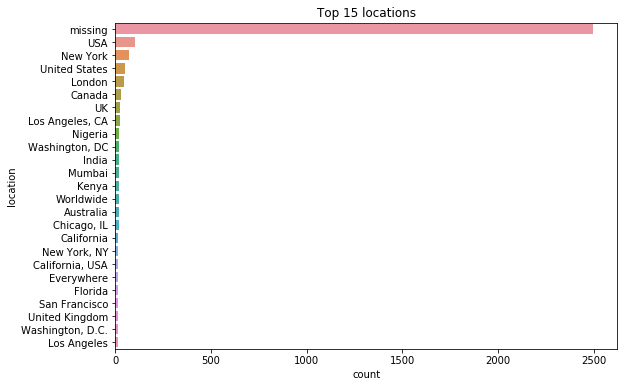

In [210]:
plt.figure(figsize=(9,6))
sns.countplot(y=train.location, order = train.location.value_counts().iloc[:25].index)
plt.title('Top 15 locations')
plt.show()

*I am going to group the location variable by countries using the function country search.*

In [211]:
train['country'] = train.location.apply(country_search)
test['country'] = test.location.apply(country_search)

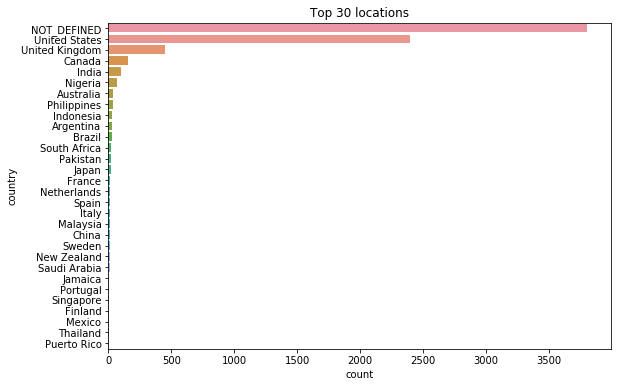

In [212]:
plt.figure(figsize=(9,6))
sns.countplot(y=train.country, order = train.country.value_counts().iloc[:30].index)
plt.title('Top 30 locations')
plt.show()

In [213]:
train['country'] = np.where(((train['country'] == 'NOT_DEFINED') & (train['location'] == 'missing')), 'EMPTY',train['country'])
test['country'] = np.where(((test['country'] == 'NOT_DEFINED') & (test['location'] == 'missing')), 'EMPTY',test['country'])

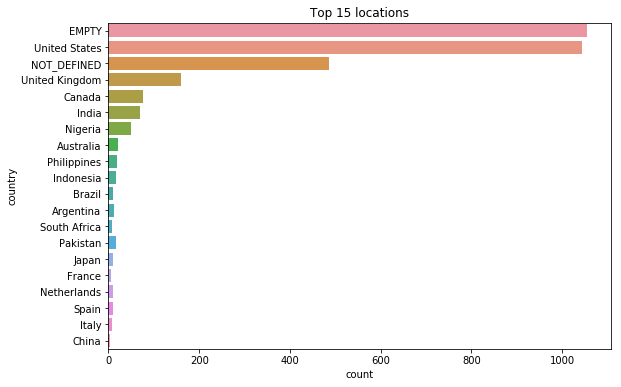

In [214]:
plt.figure(figsize=(9,6))
sns.countplot(y=train.country[train['target'] == 1], order = train.country.value_counts().iloc[:20].index)
plt.title('Top 15 locations')
plt.show()

In [215]:
train['country'] = np.where(train['country'] == 'EMPTY', 'empty', 
                            np.where(train['country'] == 'United States', 'usa',
                                    np.where(train['country'] == 'NOT_DEFINED', 'not_valid',
                                            np.where(train['country'] == 'United Kingdom', 'uk',
                                                            np.where(train['country'] == 'India', 'india',
                                                                    np.where(train['country'] == 'Nigeria', 'nigeria',
                                                                            'others'))))))

test['country'] = np.where(test['country'] == 'EMPTY', 'empty', 
                            np.where(test['country'] == 'United States', 'usa',
                                    np.where(test['country'] == 'NOT_DEFINED', 'not_valid',
                                            np.where(test['country'] == 'United Kingdom', 'uk',
                                                            np.where(test['country'] == 'India', 'india',
                                                                    np.where(test['country'] == 'Nigeria', 'nigeria',
                                                                            'others'))))))

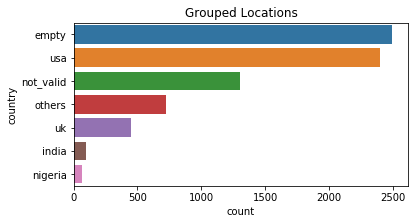

In [216]:
plt.figure(figsize=(6,3))
sns.countplot(y=train.country, order = train.country.value_counts().iloc[:].index)
plt.title('Grouped Locations')
plt.show()

*Now as the data is cleaner we can see that apparently Nigeria and India seem to have high level of fake tweets coming from them.*

In [217]:
num_fake = train.groupby(['country'])['target'].sum()
num_tot = train.groupby(['country'])['country'].count()
proportion = num_fake/num_tot
df_countries = pd.DataFrame()
df_countries['prop_fake_new'] = proportion
df_countries.sort_values(by=['prop_fake_new'], ascending = False)

,prop_fake_new
country,
nigeria,0.710145
india,0.696970
others,0.499312
usa,0.435363
empty,0.421938
not_valid,0.373272
uk,0.354911


In [218]:
dummies_train = pd.get_dummies(train['country'],prefix = 'country', drop_first=True)
dummies_test = pd.get_dummies(test['country'],prefix = 'country', drop_first=True)
train = pd.concat([train, dummies_train], axis = 1)
test = pd.concat([test, dummies_test], axis = 1)

*Let's create some structural features to describe the comment length, the number of digits, words, upper case letters, punctuations,
spaces, ads, hashes, mean word length in a comment and visualize them.*

In [219]:
# Train data treatment:

train['comment_length'] = [len(word_tokenize(item)) for item in train['text']]
# Creates a list of lists, containing the tokens from text column.
tokens = [word_tokenize(item) for item in train['text']]

train['words_number'] = [len([word for word in item if word.isalpha()]) for item in tokens]

train['punctuation_number'] = [len([word for word in item if not word.isalnum()]) for item in tokens]

train['digits_number'] = [len([word for word in item if word.isdigit()]) for item in tokens]

train['mean_word_length'] = train['text'].apply(lambda x: sum([len(i) for i in x if x.split()])/len(x.split()))

train['spaces_number'] = train['text'].apply(lambda x: len(x.split()))

train['upper_letters_number'] = train['text'].apply(lambda x: len([i for i in x if i.isupper()]))

train['ats_number'] = train['text'].apply(lambda x: len([i for i in x if i == '@']))

train['hash_number'] = train['text'].apply(lambda x: len([i for i in x if i == '#']))


# Test data treatment:

test['comment_length'] = [len(word_tokenize(item)) for item in test['text']]
# Creates a list of lists, containing the tokens from text column.
tokens_ = [word_tokenize(item) for item in test['text']]

test['words_number'] = [len([word for word in item if word.isalpha()]) for item in tokens_]

test['punctuation_number'] = [len([word for word in item if not word.isalnum()]) for item in tokens_]

test['digits_number'] = [len([word for word in item if word.isdigit()]) for item in tokens_]

test['mean_word_length'] = test['text'].apply(lambda x: sum([len(i) for i in x if x.split()])/len(x.split()))

test['spaces_number'] = test['text'].apply(lambda x: len(x.split()))

test['upper_letters_number'] = test['text'].apply(lambda x: len([i for i in x if i.isupper()]))

test['ats_number'] = test['text'].apply(lambda x: len([i for i in x if i == '@']))

test['hash_number'] = test['text'].apply(lambda x: len([i for i in x if i == '#']))

**Comment_length.**

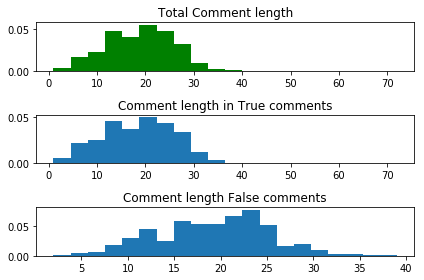

In [178]:
visual('comment_length', 'target')

*Even though there are some really long comments among the true once, on average the false once are longer with the mean
of 19.22 and standard deviation of 6 while the true comments have the mean of 18.6 and standard deviation 7.4.*

In [179]:
descr_stats(train, 'comment_length', 'target')

,total,target_0,target_1
count,7541.000000,4317.000000,3224.000000
mean,18.860098,18.596942,19.212469
std,6.868231,7.431751,6.014912
min,1.000000,1.000000,2.000000
25%,14.000000,13.000000,15.000000
50%,19.000000,19.000000,20.000000
75%,24.000000,24.000000,24.000000
max,72.000000,72.000000,39.000000


**Words_number.**

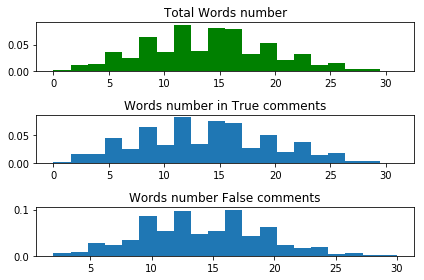

In [180]:
visual('words_number', 'target')

*On average the false comments contain more words than the true once with the mean
of 14 and standard deviation of 4.9 while the true comments have the mean of 13.7 and standard deviation 6.*

In [181]:
descr_stats(train, 'words_number', 'target')

,total,target_0,target_1
count,7541.000000,4317.000000,3224.000000
mean,13.866729,13.748205,14.025434
std,5.606304,6.053119,4.941668
min,0.000000,0.000000,2.000000
25%,10.000000,9.000000,10.000000
50%,14.000000,14.000000,14.000000
75%,18.000000,18.000000,17.000000
max,31.000000,31.000000,30.000000


**Punctuation_number.**

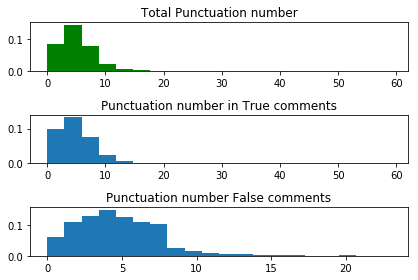

In [182]:
visual('punctuation_number', 'target')

*While we can observe quite similar destributions when comes to the mean (4,56 and 4.77), first, second and third percentiles (2,4,6 and 3,4,6) in the cases of true and false comments respectively, true comments tend to have more extreme outliers.*

In [183]:
descr_stats(train, 'punctuation_number', 'target')

,total,target_0,target_1
count,7541.000000,4317.000000,3224.000000
mean,4.653759,4.561038,4.777916
std,3.258431,3.549634,2.817601
min,0.000000,0.000000,0.000000
25%,3.000000,2.000000,3.000000
50%,4.000000,4.000000,4.000000
75%,6.000000,6.000000,6.000000
max,59.000000,59.000000,23.000000


**Digits_number.**

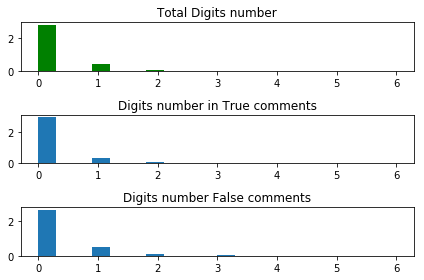

In [184]:
visual('digits_number', 'target')

*The majority of the comments don't have digits in them, but in the case of the false comments the mean number is higher than in the case of true comments.*

In [185]:
descr_stats(train, 'digits_number', 'target')

,total,target_0,target_1
count,7541.000000,4317.000000,3224.000000
mean,0.200902,0.159833,0.255893
std,0.543424,0.496912,0.595747
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000
max,6.000000,6.000000,6.000000


**Mean_word_length.**

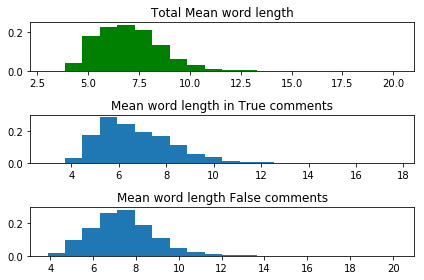

In [186]:
visual('mean_word_length', 'target')

*On average false comments tend to have more lengthy words than the true once with the mean of 7.4, first, second and third percentiles of 6.4, 7.3 and 8.2 respectively and the maximum of 20.16.*

In [187]:
descr_stats(train, 'mean_word_length', 'target')

,total,target_0,target_1
count,7541.000000,4317.000000,3224.000000
mean,7.055828,6.793769,7.406730
std,1.662048,1.722718,1.507683
min,3.000000,3.000000,3.875000
25%,5.818182,5.545455,6.400000
50%,6.857143,6.476190,7.294118
75%,8.000000,7.750000,8.235294
max,20.166667,17.714286,20.166667


**Spaces_number.**

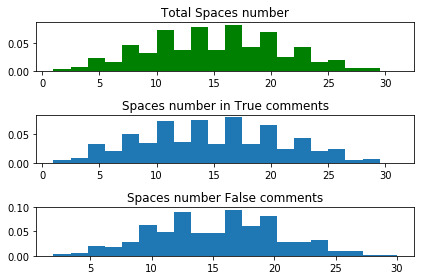

In [188]:
visual('spaces_number', 'target')

The distributions are quite similar, though the true comments seem to be more spread.

In [189]:
descr_stats(train, 'spaces_number', 'target')

,total,target_0,target_1
count,7541.000000,4317.000000,3224.000000
mean,14.881315,14.681492,15.148883
std,5.732924,6.160599,5.093130
min,1.000000,1.000000,2.000000
25%,11.000000,10.000000,11.000000
50%,15.000000,15.000000,15.000000
75%,19.000000,19.000000,19.000000
max,31.000000,31.000000,30.000000


**Upper_letters_number.**

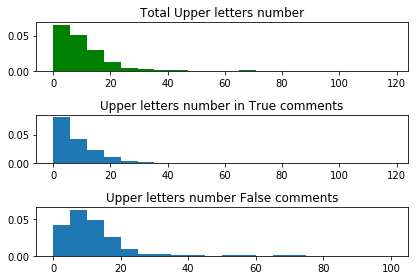

In [190]:
visual('upper_letters_number', 'target')

False comments seem to have more upper case letters on average (10.8 while true comments mean is 9.2), but the true comments are more spread
with the standard deviation of 10.94 which is higher than in the case of false commnets (9.6), which could be explained by the extreme outliers.

In [191]:
descr_stats(train, 'upper_letters_number', 'target')

,total,target_0,target_1
count,7541.000000,4317.000000,3224.000000
mean,9.933961,9.211721,10.901055
std,10.465702,10.966442,9.672603
min,0.000000,0.000000,0.000000
25%,3.000000,2.000000,5.000000
50%,7.000000,6.000000,9.000000
75%,13.000000,12.000000,14.000000
max,118.000000,118.000000,100.000000


**Ats_number.**

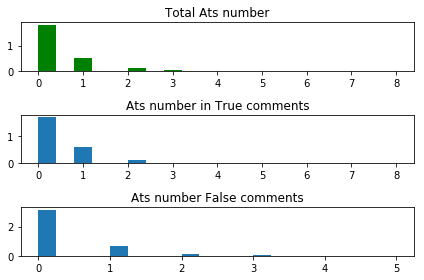

In [192]:
visual('ats_number', 'target')

True comments have more ats than the false once which can be explained by the fact that there are more discussions about true news than the false once.

In [193]:
descr_stats(train, 'ats_number', 'target')

,total,target_0,target_1
count,7541.000000,4317.000000,3224.000000
mean,0.364673,0.427843,0.280087
std,0.722429,0.776564,0.633162
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,1.000000,1.000000,0.000000
max,8.000000,8.000000,5.000000


**Key_word.**

*Let's take a look at a key word variable. Some of them are missing.
So we are going to create a dictionary with texts as keys and keywords as values and replace the missing values with the keywords of the same texts since we know that some texts are repeated.
Then I will visualize the rusults.*

In [220]:
train_aux =  pd.concat([train[list(test.columns)],test], axis = 0)
train_aux.drop_duplicates(subset='text', inplace= True)
kw_dict = dict(zip(train_aux['text'][train_aux['keyword'].notna()],train_aux['keyword'][train_aux['keyword'].notna()]))

# Train data treatment:
train['keyword'] = train['keyword'].fillna(train['text'].map(kw_dict))
train['keyword'].fillna('', inplace = True)
train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', ''))

# Test data treatment:
test['keyword'] = test['keyword'].fillna(train['text'].map(kw_dict))
test['keyword'].fillna('', inplace = True)
test['keyword'] = test['keyword'].apply(lambda x: x.replace('%20', ''))

full = pd.concat([train, test], axis = 0)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  from ipykernel import kernelapp as app


*Looking at the word clouds of true and false comments it´s clear that latter fall into more contentious topics like wreckage, derailment, etc., and since it's human labeled it could be useful to add the dummies of the keywords to as predictors as well.*

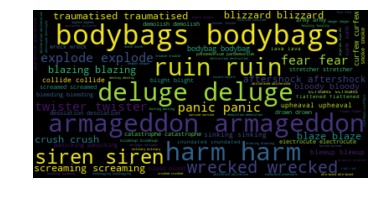

In [221]:
cloud_comment_words = WordCloud(background_color="black").generate(
    ' '.join(list(train['keyword'][train['target'] == 0])))
plt.imshow(cloud_comment_words, interpolation='bilinear') 
plt.axis("off")
plt.show()

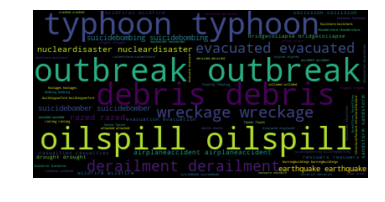

In [222]:
cloud_comment_words = WordCloud(background_color="black").generate(
    ' '.join(list(train['keyword'][train['target'] == 1])))
plt.imshow(cloud_comment_words, interpolation='bilinear') 
plt.axis("off")
plt.show()

*Now if we take a look at the unique values of the keyword column of the full data set we can spot that some of the topics have the same root, like 'bloody' and 'blood', and therefore can be stemmed to reduce the number of the unique values of the keyword.*

In [223]:
len(full['keyword'].unique())

222

In [311]:
full['keyword'].unique()[:25]

array(['', 'ablaz', 'accid', 'aftershock', 'airplaneaccid', 'ambul',
       'annihil', 'apocalyps', 'armageddon', 'armi', 'arson', 'arsonist',
       'attack', 'avalanch', 'battl'], dtype=object)

In [224]:
porter = PorterStemmer()
full['keyword'] = full['keyword'].apply(porter.stem)
    

In [225]:
len(full['keyword'].unique())

166

*Now let's dummify the keyword variable and create key_word_full data frame with the dummies of the keyword and the id of each comment, and then merge it with train and test data sets on 'id'.*

In [226]:
key_word_full = pd.get_dummies(full['keyword'],prefix = 'kw_', drop_first=True)
key_word_cols = [i for i in key_word_full.columns]
key_word_full['id'] = full['id']

In [227]:
train = pd.merge(train, key_word_full,
                how = 'left',
                on = 'id')

test = pd.merge(test, key_word_full,
                how = 'left',
                on = 'id')

*Let's do some text cleaning.*

In [252]:
# Train data treatment:
train['text_modif'] = train['text'].apply(text_prepro)

# Test data treatment:
test['text_modif'] = test['text'].apply(text_prepro)


*To check the frequency of the words we are going to use the Collection from Counter.*

In [229]:
word_freq = Counter(chain.from_iterable(list(train['text_modif'].str.split())))
most_common = word_freq.most_common()

word_freq_t1 = Counter(chain.from_iterable(list(train['text_modif'][train['target'] == 1].str.split())))
most_common_t1 = word_freq_t1.most_common()

word_freq_t0 = Counter(chain.from_iterable(list(train['text_modif'][train['target'] == 0].str.split())))
most_common_t0 = word_freq_t0.most_common()

In [309]:
most_common_t1[:25]

[('link', 2510),
 ('gape', 1355),
 ('org', 1290),
 ('cardin', 780),
 ('person', 625),
 ('date', 442),
 ('loc', 258),
 ('fire', 255),
 ('fac', 167),
 ('time', 165),
 ('bomb', 163),
 ('kill', 157),
 ('via', 121),
 ('disast', 118),
 ('flood', 117),
 ('crash', 114),
 ('peopl', 106),
 ('suicid', 106),
 ('polic', 104),
 ('like', 103),
 ('famili', 102),
 ('attack', 102),
 ('home', 100),
 ('train', 99),
 ('evacu', 98)]

In [310]:
most_common_t0[:25]

[('link', 2197),
 ('org', 1235),
 ('person', 1118),
 ('cardin', 544),
 ('date', 441),
 ('gape', 412),
 ('like', 310),
 ('get', 222),
 ('time', 204),
 ('work', 194),
 ('new', 154),
 ('go', 147),
 ('art', 139),
 ('love', 119),
 ('bodi', 109),
 ('bag', 102),
 ('video', 100),
 ('would', 100),
 ('see', 99),
 ('scream', 99),
 ('make', 98),
 ('via', 98),
 ('want', 96),
 ('look', 94),
 ('know', 93)]

Next, we will compute the mean number of different parts of speech and name enteties used in fake and real comments and compare the values. If there is a remarkable difference, then there is a good chance that using the created feature in fake news detector will improve its performance.

In [ ]:
spacy_counter(train, 'part_of_speech', 'text', 'target')

###### 1. It looks like the number of nouns (NOUN with the mean difference equal to 0.69), proper names (PROPN with the mean difference equal to 0.74), pronouns (PRON with the mean difference equal to 0.56) and adposition (ADP with the mean difference equal to 0.43) might do do some good to our model. Let's take a look at the number of parts of speech in the comments.

In [232]:
#Train data treatment:
train['text'] = train['text'].apply(replace_elem)
train['NOUN'] = train['text'].apply(lambda x: part_speech(x,'NOUN'))
train['PROPN'] = train['text'].apply(lambda x: part_speech(x,'PROPN'))
train['PRON'] = train['text'].apply(lambda x: part_speech(x,'PRON'))
train['ADP'] = train['text'].apply(lambda x: part_speech(x,'ADP'))

#Te data treatment:
test['text'] = test['text'].apply(replace_elem)
test['NOUN'] = test['text'].apply(lambda x: part_speech(x,'NOUN'))
test['PROPN'] = test['text'].apply(lambda x: part_speech(x,'PROPN'))
test['PRON'] = test['text'].apply(lambda x: part_speech(x,'PRON'))
test['ADP'] = test['text'].apply(lambda x: part_speech(x,'ADP'))

*Content Features: Content features are based on comments’ textual aspects and include polarity (the average positive or negative feelings expressed a comment), subjectivity (a score of whether a tweet is objective or subjective).*
*But before we should get rid of the hash tags, ats, etc.*

In [233]:
# Train data treatment:
stop_words = set(stopwords.words('english'))
new_stopwords = ["i'm", "im", "there's", "that's", "wasnt"]
new_stopwords_list = stop_words.union(new_stopwords)

train['text'] = train['text'].apply(lambda x: ' '.join([i for i in x.lower().split() if (i.isalpha() and i not in new_stopwords_list)]))
train['commenet_polar'] = train['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
train['commenet_polar'] = np.where(((train['commenet_polar'] <= 1) & (train['commenet_polar'] >= 0.5)), 3,
                                  np.where(((train['commenet_polar'] < 0.5) & (train['commenet_polar'] >= 0)), 2,
                                           np.where(((train['commenet_polar'] < 0) & (train['commenet_polar'] >= -0.5)), 1, 0)))

train['commenet_subject'] = train['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

# Test data treatment:
test['text'] = test['text'].apply(lambda x: ' '.join([i for i in x.lower().split() if (i.isalpha() and i not in new_stopwords_list)]))
test['commenet_polar'] = test['text'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
test['commenet_polar'] =  np.where(((test['commenet_polar'] <= 1) & (test['commenet_polar'] >= 0.5)), 3,
                                  np.where(((test['commenet_polar'] < 0.5) & (test['commenet_polar'] >= 0)), 2,
                                           np.where(((test['commenet_polar'] < 0) & (test['commenet_polar'] >= -0.5)), 1, 0)))

test['commenet_subject'] = test['text'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

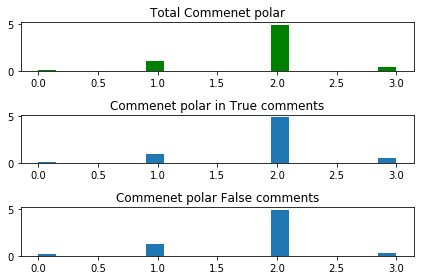

In [234]:
visual('commenet_polar', 'target')

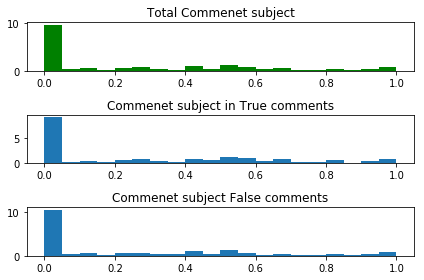

In [235]:
visual('commenet_subject', 'target')

# Feature selection part.


*Feature importance is an inbuilt class that comes with Tree Based Classifiers, we will be using Extra Tree Classifier for extracting the top n features for the dataset.*

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.00488295 0.00327855 0.01167846 0.01203837 0.00938992 0.02431317
 0.07108438 0.07094886 0.06880498 0.02446042 0.09864295 0.07160885
 0.08865016 0.03866201 0.03667984 0.07291299 0.07411499 0.05939925
 0.0626449  0.03428806 0.06151594]


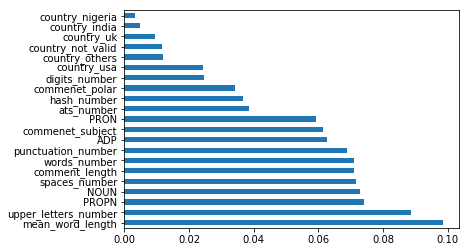

In [260]:
X = train[['country_india', 'country_nigeria', 'country_not_valid', 'country_others', 'country_uk', 'country_usa',
           'comment_length','words_number', 'punctuation_number', 'digits_number', 'mean_word_length', 
           'spaces_number', 'upper_letters_number', 'ats_number', 'hash_number', 'NOUN', 'PROPN', 'PRON', 'ADP',
           'commenet_polar', 'commenet_subject']] 

y = train['target']
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(len(X)-1).plot(kind='barh')
plt.show()

In [261]:
train.to_csv("/kaggle/master.csv")

# Modelling part.


In [262]:
master = pd.read_csv("/kaggle/master.csv")

In [279]:
ad_vars = [ 'country_india', 'country_nigeria', 'country_not_valid', 'country_others', 'country_uk', 'country_usa',
           'comment_length','words_number', 'punctuation_number', 'digits_number', 'mean_word_length', 
           'spaces_number', 'upper_letters_number', 'ats_number', 'hash_number', 'NOUN', 'PROPN', 'PRON', 'ADP',
           'commenet_polar', 'commenet_subject']
tot_cols = ad_vars + key_word_cols + ['text_modif']

In [280]:
master = master[master.text_modif.notna()]

In [281]:
X = master[tot_cols]
y = master.target

# Logistic Regression.

*Bag of words.
Using (1,3) n-gramm baw vectores and new features.*

In [282]:
matr_lr, cols_lr = text_vectorizer(text_column = 'text_modif', ngram_range = (1,3), x_set = X, add_col_list = ad_vars,
                                   add_keyword = key_word_cols, 
                                   min_df = 0.001, stand_sc = False)

X_train, X_test, y_train, y_test = train_test_split(matr_lr, y, test_size=0.06, 
                                                    stratify = y, random_state=42)

*Let's train a logistic regression model and calculate its F1 score.*

In [289]:
log_reg = LogisticRegression(C=0.05).fit(X_train, y_train)

log_preds = log_reg.predict(X_test)

print('F1 of logistic regression reg 0.01:', f1_score(y_test, log_preds, average='micro'))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


F1 of logistic regression reg 0.01: 0.8004434589800443


#  Multinomial model.

*A unigram vectorizer on the text data and key words variables.*

In [294]:
matr_mn, cols_mn = text_vectorizer(text_column = 'text_modif', ngram_range = (1,1), x_set = X, add_col_list = None,
                                   add_keyword = None, 
                                   min_df = 0.001, stand_sc = False)

X_train, X_test, y_train, y_test = train_test_split(matr_mn, y, test_size=0.06, 
                                                    stratify = y, random_state=42)

*Here we are going to iterate over a range of values of alpha to optimize the model.*

In [295]:
alphas = np.arange(0, 1, 0.1)

for alpha in alphas:
    print('Alpha: ', alpha)
    print('Score: ', train_and_predict(alpha, X_train, y_train, X_test, y_test))
    print()


Alpha:  0.0
Score:  0.7982261640798226

Alpha:  0.1
Score:  0.7982261640798226

Alpha:  0.2
Score:  0.7937915742793792

Alpha:  0.30000000000000004


/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Score:  0.7915742793791575

Alpha:  0.4
Score:  0.7915742793791575

Alpha:  0.5
Score:  0.7937915742793792

Alpha:  0.6000000000000001
Score:  0.7937915742793792

Alpha:  0.7000000000000001
Score:  0.7915742793791575

Alpha:  0.8
Score:  0.7915742793791575

Alpha:  0.9
Score:  0.7893569844789358



In [296]:
clf = MultinomialNB(alpha = 0.2)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)
print('F1 of Multinomial NB: ', f1_score(y_test, predictions, average='micro'))

F1 of Multinomial NB:  0.7937915742793792


*Let's explore the model and print out the most and the least important features.*

In [299]:
class_labels = clf.classes_

feature_names = cols_mn

# Zip the feature names together with the coefficient array and sort by weights: feat_with_weights
feat_with_weights = sorted(zip(clf.coef_[0], feature_names))

# Print the first class label and the top 20 feat_with_weights entries
print('Top 20 lowest values (less predictive features)')
print()
print(class_labels[0], feat_with_weights[:20])
print()
print('*******************************************************************************************************************************')
print()
# Print the second class label and the bottom 20 feat_with_weights entries
print('top 20 highest values (highest predictive features)')
print()
print(class_labels[1], feat_with_weights[-20:])


Top 20 lowest values (less predictive features)

0 [(-11.53195328237481, 'access'), (-11.53195328237481, 'beehiv'), (-11.53195328237481, 'bitch'), (-11.53195328237481, 'cabl'), (-11.53195328237481, 'career'), (-11.53195328237481, 'charact'), (-11.53195328237481, 'choic'), (-11.53195328237481, 'easi'), (-11.53195328237481, 'either'), (-11.53195328237481, 'faux'), (-11.53195328237481, 'fill'), (-11.53195328237481, 'finish'), (-11.53195328237481, 'glass'), (-11.53195328237481, 'hair'), (-11.53195328237481, 'handbag'), (-11.53195328237481, 'hire'), (-11.53195328237481, 'hobo'), (-11.53195328237481, 'leather'), (-11.53195328237481, 'lucki'), (-11.53195328237481, 'mayhem')]

*******************************************************************************************************************************

top 20 highest values (highest predictive features)

1 [(-5.442908406927964, 'evacu'), (-5.442908406927964, 'famili'), (-5.442908406927964, 'polic'), (-5.442908406927964, 'suicid'), (-5.3985552

# Neural NetWork model.

*A data frame based on (1,2) gramm vectorized text using 1000 most frequent words, with key words and created varibales.
The data has been scaled as well.*

In [300]:
matr_nr, cols_nr = text_vectorizer(text_column = 'text_modif', ngram_range = (1,2), x_set = X, add_col_list = ad_vars,
                                   add_keyword = key_word_cols,  max_features = None, min_df = 0.001, stand_sc = True)

X_train, X_test, y_train, y_test = train_test_split(matr_nr, y, test_size=0.06, stratify = y, random_state=42)


*Grid Search for the best parameters.*

In [301]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import Callback
from sklearn.metrics import f1_score
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import BatchNormalization
from keras import optimizers

ns = X_train.shape[0] # number of samples in training data set.
no = 1                # number of output neurons.
ni = X_train.shape[1] # number of input neurons
a = 6                 # an arbitrary scaling factor usually 2-10.
nh = ns/(a**(ni + no))# number of hidden layer neurons

# Creates a model given an activation learning rate and number of layers.

def create_model(drop_out, learning_rate, number_of_layers=1):
    
    model = Sequential()
    model.add(Dense(ni, input_dim= ni, activation='relu'))
    model.add(Dropout(drop_out))
    if number_of_layers == 2:
        model.add(Dense(nh, activation='relu'))
        model.add(Dropout(drop_out))
    model.add(Dense(1, activation='sigmoid'))
    sgd = optimizers.Adamax(beta_1 = 0.4, beta_2 = 0.999)
    model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
    
    return model



Using TensorFlow backend.


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

# Create a KerasClassifier
model = KerasClassifier(build_fn = create_model)

# Define the parameters to try out
params = {'batch_size': [60, 100, 200, 300,  500, 600], 
          'epochs': [50, 100, 300], 
          'number_of_layers': [1,2],
          'drop_out': [ 0.2, 0.5],
          'learning_rate': [0.1, 0.01, 0.001, 0.0001]}

# Create a grid search cv object passing in the parameters to try
sg = GridSearchCV(model, param_grid = params, cv = 3, scoring = 'f1_micro')

sg.fit(X_train, y_train) 

In [ ]:
#{'batch_size': 500, 'drop_out': 0.2, 'epochs': 200, 'learning_rate': 0.0001, 'number_of_layers': 1}
print(sg.best_params_)

In [302]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

# Create a Sequential model
model = Sequential()

model.add(Dense(ni, input_dim=ni, activation='relu'))
model.add(Dropout(0.1))
#model.add(Dense(no, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))
sgd = optimizers.Adamax(learning_rate=0.0001, beta_1 = 0.9, beta_2 = 0.999)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1838)              3380082   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1838)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1839      
Total params: 3,381,921
Trainable params: 3,381,921
Non-trainable params: 0
_________________________________________________________________


In [303]:
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience = 10)
#Save the best model as best_banknote_model.hdf5
modelCheckpoint = ModelCheckpoint('Nnr_model.hdf5', save_best_only=True)
history = model.fit(X_train, y_train, epochs=100, 
                    callbacks=[modelCheckpoint,monitor_val_acc],
                    batch_size=200,
                    validation_data = (X_test, y_test))


Train on 7056 samples, validate on 451 samples
Epoch 1/100
7056/7056 [==============================] - 2s 297us/step - loss: 0.6751 - accuracy: 0.6052 - val_loss: 0.6604 - val_accuracy: 0.6386
Epoch 2/100
7056/7056 [==============================] - 2s 275us/step - loss: 0.6482 - accuracy: 0.6460 - val_loss: 0.6392 - val_accuracy: 0.6851
Epoch 3/100
7056/7056 [==============================] - 2s 229us/step - loss: 0.6278 - accuracy: 0.6901 - val_loss: 0.6204 - val_accuracy: 0.7251
Epoch 4/100
7056/7056 [==============================] - 2s 226us/step - loss: 0.6085 - accuracy: 0.7259 - val_loss: 0.6028 - val_accuracy: 0.7494
Epoch 5/100
7056/7056 [==============================] - 2s 230us/step - loss: 0.5899 - accuracy: 0.7581 - val_loss: 0.5863 - val_accuracy: 0.7672
Epoch 6/100
7056/7056 [==============================] - 2s 256us/step - loss: 0.5723 - accuracy: 0.7708 - val_loss: 0.5706 - val_accuracy: 0.7761
Epoch 7/100
7056/7056 [==============================] - 2s 248us/step 

*Exploring the model.*

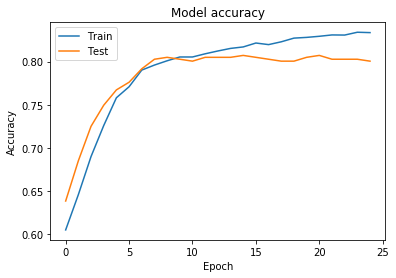

In [304]:
plt.figure()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'])
plt.show()

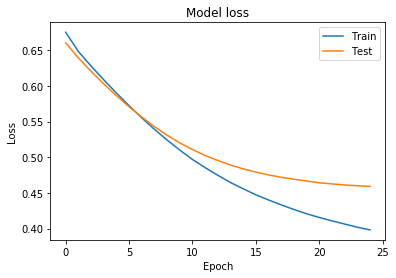

In [305]:
plt.figure()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'])
plt.show()

In [306]:
predictions = model.predict(X_test)

predictions = [round(i[0]) for i in predictions]
print('F1 of Keras Net Work: ', f1_score(y_test, predictions, average='micro'))

F1 of Keras Net Work:  0.8004434589800443


*Applying Logistic Regression Model to the test data.*

In [290]:
test_lr, cols = text_vectorizer(text_column = 'text_modif', ngram_range = (1,3), x_set = test, add_col_list = ad_vars,
                                   add_keyword = key_word_cols, 
                                   min_df = 0.001, stand_sc = False)
test_lr = col_replacer(columns = cols_lr, df = test_lr)

In [291]:
lr = predictor(model = log_reg, df = test_lr)
lr.to_csv('Log_reg.csv', index=False)
FileLink(r'Log_reg.csv')

/kaggle/working/Log_reg.csv

*Applying Multinomial Model to the test data.*

In [297]:
test_mn, cols1 = text_vectorizer(text_column = 'text_modif', ngram_range = (1,1), x_set = test, add_col_list = None,
                                   add_keyword = key_word_cols,
                                   max_features = None, min_df = 0.001, stand_sc = False)

test_mn = col_replacer(columns = cols_mn, df = test_mn)

In [298]:
mn = predictor(model = clf, df = test_mn)
mn.to_csv('mult_nom.csv', index=False)
FileLink(r'mult_nom.csv')

/kaggle/working/mult_nom.csv

*Applying Neural Net Model to the test data.*

In [307]:
test_nr, cols2 = text_vectorizer(text_column = 'text_modif', ngram_range = (1,2), x_set = test, add_col_list = ad_vars,
                                   add_keyword = key_word_cols,  max_features = None, min_df = 0.001, stand_sc = True)

test_nr = col_replacer(columns = cols_nr, df = test_nr)

In [308]:
from keras.models import load_model
nnr_model = load_model('Nnr_model.hdf5')
nr = predictor(model = nnr_model, df = test_nr)
nr.to_csv('neural_net.csv', index=False)
FileLink(r'neural_net.csv')

/kaggle/working/neural_net.csv

*As a conclusion of this project I must say there hasn't been much difference in the performance of the three models. On average they have 0.80
F1 scroe on the test and 0.79 on the validation data. I started with the avrege score of 0.76 and managed to improve it by using text prepro -
cessing tecniques such as spelling corection, entity labeling and chosing stemming over lematization.*